In [32]:
import sys
# add path to gp-quadrature
sys.path.append('/Users/colecitrenbaum/Documents/GPs/gp-quadrature')
sys.path.append('/Users/colecitrenbaum/Documents/GPs/gp-quadrature/kernels')
from kernels import SquaredExponential
from vanilla_gp_sampling import sample_bernoulli_gp
from efgpnd import ToeplitzND, compute_convolution_vector_vectorized_dD

import torch
from efgpnd import NUFFT
from cg import ConjugateGradients
from torch import vmap


In [33]:
#default to float64
torch.set_default_dtype(torch.float64)

# --- Parameters ---
n = 2_000  # Number of points
d = 1  # Dimensionality of the input space
true_length_scale =0.2
true_variance = 1
dtype = torch.float64  # Use float64 as in the original example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
print(f"Using device: {device}")

# --- Generate Input Points ---
# Generate random points in d-dimensional space from -1 to 1
x = torch.rand(n, d, dtype=dtype, device=device) * 2 - 1
y,f = sample_bernoulli_gp(x,length_scale=true_length_scale,variance=true_variance)
rdtype = torch.float64
cdtype = torch.complex128


Using device: cpu
Cholesky succeeded after adding jitter.


In [34]:
# # --- Parameters ---
# n = 40_000  # Number of points
# d = 2  # Dimensionality of the input space
# dtype = torch.float64  # Use float64 for numerical stability
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# true_noise_variance = 0.2
# # --- Generate Input Points ---
# # Generate random points in d-dimensional space from -1 to 1
# x = torch.rand(n, d, dtype=dtype, device=device) * 2 - 1
# x = x.to(device, dtype)
# # --- Define the true function ---
# def true_function(x):
#     """
#     A 2D function to generate synthetic data
#     x: tensor of shape [n, 2]
#     """
#     # Example of a non-linear function with some interesting features
#     return torch.sin(3 * x[:, 0]) * torch.cos(4 * x[:, 1]) + \
#            0.5 * torch.exp(-((x[:, 0] - 0.3)**2 + (x[:, 1] + 0.3)**2) / 0.3) + \
#            0.7 * torch.sin(2 * torch.pi * (x[:, 0]**2 + x[:, 1]**2))

# # --- Generate target values with noise ---
# # Compute true function values
# f = true_function(x)

# y = torch.bernoulli(torch.sigmoid(f)).to(device, dtype)

# print(f"Generated {n} points with shape {x.shape}")
# print(f"Using device: {device}")



In [35]:
import torch
import torch.nn as nn
from typing import List, Iterator, Tuple, Optional, Union
from torch.optim import Adam
from utils.kernels import get_xis
import math

class qVariationalParams(nn.Module): # inherits from nn.Module
    def __init__(self):
        """

        """
        super().__init__()
        self.Delta = nn.Parameter(torch.full((n,), 1e-3, dtype=torch.float64))

In [36]:
q = qVariationalParams()
kernel = SquaredExponential(dimension = d,init_lengthscale=0.5*true_length_scale,init_variance=2*true_variance)
eps = 1e-3


dtype = x.dtype
rdtype = dtype 
x       = x.to(device, dtype)
y       = y.to(device, dtype)
if x.ndim == 1:
    x = x.unsqueeze(-1)
x0 = x.min(dim=0).values  
x1 = x.max(dim=0).values  

if x.ndim == 1:
    x = x.unsqueeze(-1)
d = x.shape[1]
domain_lengths = x1 - x0
L = domain_lengths.max()
N = x.shape[0]
xis_1d, h, mtot = get_xis(kernel_obj=kernel, eps=eps, L=L, use_integral=True, l2scaled=False)
grids = torch.meshgrid(*(xis_1d for _ in range(d)), indexing='ij') # makes tensor product Jm 
xis = torch.stack(grids, dim=-1).view(-1, d) 
ws2 = kernel.spectral_density(xis).to(dtype=cdtype) * h**d
ws = torch.sqrt(ws2) # (mtot**d,1)


# x = x.to(device, rdtype)
# y = y.to(device, rdtype)


In [37]:
ws

tensor([0.0094+0.j, 0.0155+0.j, 0.0247+0.j, 0.0380+0.j, 0.0566+0.j, 0.0814+0.j, 0.1130+0.j,
        0.1516+0.j, 0.1964+0.j, 0.2459+0.j, 0.2973+0.j, 0.3474+0.j, 0.3920+0.j, 0.4274+0.j,
        0.4502+0.j, 0.4580+0.j, 0.4502+0.j, 0.4274+0.j, 0.3920+0.j, 0.3474+0.j, 0.2973+0.j,
        0.2459+0.j, 0.1964+0.j, 0.1516+0.j, 0.1130+0.j, 0.0814+0.j, 0.0566+0.j, 0.0380+0.j,
        0.0247+0.j, 0.0155+0.j, 0.0094+0.j])

In [38]:
def naive_kernel(x,xis):
    F_train = torch.exp(2 * math.pi * 1j * torch.matmul(x, xis.T)).to(cdtype)
    return F_train
F_train = naive_kernel(x,xis)
W_F_train_star = ws.unsqueeze(1) * F_train.conj().T
K_train = (F_train * ws) @ W_F_train_star

# import torch, math

# def vanilla_e_step(K_train, y, q, 
#                    rho0=0.7, gamma=1e-3, 
#                    tol=1e-6, max_iters=20, 
#                    jitter=1e-6, verbose=True):
#     """
#     Runs the vanilla E-step for the Polya-Gamma GP classification variational update.

#     Args:
#         K_train: (n x n) kernel matrix
#         y: (n,) binary labels (0/1)
#         q: variational parameter object with attribute Delta (n,)
#         rho0: initial step size for hybrid update
#         gamma: step size decay
#         tol: tolerance for convergence
#         max_iters: maximum number of iterations
#         jitter: diagonal jitter for numerical stability
#         verbose: print progress

#     Returns:
#         m: posterior mean (n,)
#         v: posterior variance (n,)
#         acc: predictive accuracy (analytic approximation)
#     """
#     n = y.size(0)
#     I = torch.eye(n, device=y.device, dtype=y.dtype)
#     L_K = torch.linalg.cholesky(K_train + jitter*I)
#     K_inv = torch.cholesky_inverse(L_K).real

#     for it in range(max_iters):
#         # 1) build Σ via Cholesky
#         A_prec = K_inv + torch.diag(q.Delta) 
#         L_A    = torch.linalg.cholesky(A_prec)
#         Sigma  = torch.cholesky_inverse(L_A)
        
#         # 2) compute m
#         m = Sigma @ (y - 0.5)

#         # 3) compute v 
#         v = torch.diag(Sigma)

#         # 4) compute Lambda
#         c2 = (v + m.pow(2)).clamp(min=1e-12)
#         c  = torch.sqrt(c2)
#         halfc = 0.5 * c
#         Lambda = torch.tanh(halfc) / (2 * c)

#         # 5) dynamic ρ
#         rho = rho0 / (1 + gamma * it)

#         # 6) step
#         with torch.no_grad():
#             q.Delta[:] = (1 - rho) * q.Delta + rho * Lambda
#             q.Delta.clamp_(min=0.0)

#         # 5) check residual & ELBO
#         resid = (q.Delta - Lambda).abs().max().item()
#         if verbose and it % 10 == 0:
#             print(f"it {it:3d}  ρ={rho:.3f}  max|Δ−Λ|={resid:.3e}")
#         if resid < tol:
#             break

#     # 3) Final posterior
#     A     = K_inv + torch.diag(q.Delta)
#     Sigma = torch.linalg.inv(A).real
#     m     = Sigma @ (y - 0.5)
#     v     = torch.diag(Sigma)

#     # 4) Predictive accuracy (analytic logistic‐Gaussian approximation to the integral E_q sigma(f)
#     denom = torch.sqrt(1.0 + (math.pi / 8.0) * v)
#     p_hat = torch.sigmoid(m / denom)
#     acc   = (p_hat.gt(0.5).float() == y).float().mean().item()
#     if verbose:
#         print("predictive accuracy (analytic) =", acc)

#     return m, v, acc
# # m2, v, acc = vanilla_e_step(K_train, y, q)

In [39]:
cdtype

torch.complex128

In [40]:
# Create the NUFFT operator
nufft_eps = 1e-10
OUT = (mtot,)*d
nufft_op = NUFFT(x, torch.zeros_like(x), h, nufft_eps, cdtype=cdtype, device=device)

# Define the simplified helper functions
fadj = lambda v: nufft_op.type1(v, out_shape=OUT).reshape(-1)    # F* apply: nonuniform → uniform
fwd = lambda fk: nufft_op.type2(fk, out_shape=OUT)                # F apply:  uniform → nonuniform

In [41]:
# beta = torch.randn((xis.shape[0],), dtype=cdtype, device=device)
# torch.allclose(fwd(beta), F_train@beta)

In [42]:
early_stopping = True
cg_tol = 1e-5
fadj_batched = vmap(fadj, in_dims=0, out_dims=0)
fwd_batched  = vmap(fwd,  in_dims=0, out_dims=0)
def LHS_z_batch(z: torch.Tensor,delta_dummy: torch.Tensor) -> torch.Tensor:
    # ensure batch dim
    if z.dim() == 1:
        z = z.unsqueeze(0)                # (1,n)
    Dz   = z * delta_dummy                 # (J,n)
    FDz  = fadj_batched(Dz)              # (J,M)
    term = fwd_batched(FDz * ws2)        # (J,n)
    return z + term                      # (J,n)
z_test = torch.randn(q.Delta.shape[0], dtype=cdtype, device=q.Delta.device)
delta_dummy = torch.randn(q.Delta.shape[0], dtype=cdtype, device=q.Delta.device)
I = torch.eye(q.Delta.shape[0], device=q.Delta.device, dtype=cdtype)
torch.allclose((I + F_train@((torch.diag(ws2)@(F_train.conj().T)) @ torch.diag(delta_dummy))) @ z_test, LHS_z_batch(z_test,delta_dummy),atol=1e-2)
print(f'Passed LHS_z_batch = z + F* (Dz)')


Passed LHS_z_batch = z + F* (Dz)


In [43]:
def make_Sigma_z_batch(delta_buf, x0=None,cg_tol=1e-5):
    """
    Returns a function Sigma_z_batch(z) for the current delta_buf.
    Args:
        delta_buf: Current delta buffer
        x0: Optional warm start for conjugate gradients solver
    """
    apply_LHS_z_batch = lambda z: LHS_z_batch(z,delta_buf)
    def Sigma_z_batch(z: torch.Tensor) -> torch.Tensor:
        # ensure batch dim
        if z.dim() == 1:
            z = z.unsqueeze(0)
        fadj_z = fadj_batched(z)
        dsq_fadjz = (ws2)*fadj_z 
        rhs = fwd_batched(dsq_fadjz)          # (J,n) #checked this is good 

        # Use provided x0 if available, otherwise zeros
        init_x0 = x0 if x0 is not None else torch.zeros_like(rhs)  # (J,n)
        β  = ConjugateGradients(
                apply_LHS_z_batch,
                rhs,
                init_x0,
                tol=cg_tol,
                early_stopping=True
            ).solve()                      # (J,n) 

        return  β        # (n,) or (J,n)
    return Sigma_z_batch

F_train = naive_kernel(x,xis)
W_F_train_star = ws.unsqueeze(1) * F_train.conj().T
K_train = (F_train * ws) @ W_F_train_star

## test Sigma_z_batch
delta_buf = q.Delta.to(dtype=cdtype, device=device).clone()  # (n,)
Sigma_z_batch = make_Sigma_z_batch(delta_buf)
z_test = torch.randn(delta_buf.shape[0], dtype=delta_buf.dtype, device=delta_buf.device)
Sigma = torch.linalg.inv(torch.linalg.inv(K_train + 1e-6*torch.eye(K_train.shape[0])) + torch.diag(delta_buf))    
torch.allclose(Sigma_z_batch(z_test), Sigma@z_test,atol=1e-2)
print(f'Passed Sigma_z_batch = Sigma@z')

Passed Sigma_z_batch = Sigma@z


In [44]:
import torch
from torch.func import vmap
import math

# ----------------------------------------------------------------------
#  Global constants / lifts
# ----------------------------------------------------------------------
device         = y.device
cg_tol         = 1e-5
early_stopping = True

# squared weights
# ws2 = (ws**2).to(dtype=cdtype, device=device)   # shape: (M,)

# lift 1-D NUFFT routines into batched versions
# fadj: (n,) -> (M,)
# fwd : (M,) -> (n,)



# ----------------------------------------------------------------------
#  E-step
# ----------------------------------------------------------------------
def estep(
    y, q,
    max_iters=20, rho0=1.0, gamma=1e-3,
    tol=1e-4, verbose=True, J=5
):
    """
    Polyagamma GP E-step (batched, no_grad).
    Updates q.Delta in-place.
    Returns final m, Sigma_diags, and predictive acc.
    """
    n = y.numel()

    # Pre-allocate buffers
    y_center = (y.to(dtype=cdtype, device=device) - 0.5)  # (n,)
    probes   = torch.empty((J, n), device=device, dtype=rdtype)
    rhos     = rho0 / (1 + gamma * torch.arange(max_iters, device=device, dtype=rdtype))

    # A mutable copy of q.Delta used in all mat-vecs
    delta_buf = q.Delta.to(dtype=cdtype, device=device).clone()  # (n,)

    with torch.no_grad():
        for it in range(max_iters):
            # 1) update the buffer once
            delta_buf.copy_(q.Delta.to(dtype=cdtype, device=device))

            # 2) posterior mean
            Sigma_z_batch = make_Sigma_z_batch(delta_buf)
            m = Sigma_z_batch(y_center).real       # (n,)

            # 3) Hutchinson trace for diag(Σ)
            probes.normal_()                       # in-place
            Sz = Sigma_z_batch(probes)             # (J,n)
            Sigma_diags = (probes * Sz).mean(dim=0).real  # (n,)

            # 4) Lambda and Δ update
            c2     = (Sigma_diags + m.pow(2)).clamp(min=1e-12)
            c      = c2.sqrt()
            Lambda = torch.tanh(0.5 * c) / (2 * c) # (n,)

            rho = rhos[it].item()
            q.Delta.mul_(1 - rho).add_(rho * Lambda.flatten())
            q.Delta.clamp_(min=0.0)

            resid = (q.Delta - Lambda).abs().max().item()
            # if verbose and (it % 10 == 0 or resid < tol):
            if verbose:
                print(f"it {it:3d}  ρ={rho:.3f}  max|Δ−Λ|={resid:.3e}")
                print(f"q.Delta[0]: {q.Delta[0]}")
            if resid < tol:
                break

        # ------------------------------------------------------------------
        #  Final posterior recomputation
        # ------------------------------------------------------------------
        print(f'Final posterior recomputation..')
        delta_buf.copy_(q.Delta.to(dtype=cdtype, device=device))
        Sigma_z_batch = make_Sigma_z_batch(delta_buf)
        m           = Sigma_z_batch(y_center).real      # (n,)
        probes.bernoulli_(0.5).mul_(2).sub_(1)  # Rademacher: random ±1
        Sz          = Sigma_z_batch(probes)            # (J,n)
        Sigma_diags = (probes.to(dtype=cdtype) * Sz).mean(dim=0).real   # (n,)

        # Predictive accuracy (analytic logistic‐Gaussian)
        denom = torch.sqrt(1.0 + (math.pi / 8.0) * Sigma_diags)
        p_hat = torch.sigmoid(m / denom)
        acc   = (p_hat.gt(0.5) == y).float().mean().item()
        if verbose:
            print("predictive accuracy (analytic) =", acc)

    return m, Sigma_diags, acc,Sz,probes

# ----------------------------------------------------------------------
#  Example usage
# ----------------------------------------------------------------------
q = qVariationalParams()
m, Sigma_diags, acc,Sz,probes = estep(
    y, q,
    max_iters=5,
    rho0=0.8,
    gamma=1e-3,
    tol=1e-6,
    verbose=True,
    J=10
)


it   0  ρ=0.800  max|Δ−Λ|=4.980e-02
q.Delta[0]: 0.007149492081687696
it   1  ρ=0.799  max|Δ−Λ|=4.710e-02
q.Delta[0]: 0.019775955288450296
it   2  ρ=0.798  max|Δ−Λ|=3.431e-02
q.Delta[0]: 0.04559728037223379
it   3  ρ=0.798  max|Δ−Λ|=2.378e-02
q.Delta[0]: 0.09938536096301206
it   4  ρ=0.797  max|Δ−Λ|=1.941e-02
q.Delta[0]: 0.16854696521711326
Final posterior recomputation..
predictive accuracy (analytic) = 0.6244999766349792


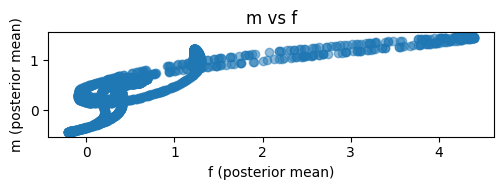

In [45]:
# plot m versus f and m2 versus f 
import matplotlib.pyplot as plt

plt.figure(figsize=(10,2))

plt.subplot(1,2,1)
plt.scatter(m.detach().cpu().numpy(), f.detach().cpu().numpy(), alpha=0.5)
plt.xlabel("f (posterior mean)")
plt.ylabel("m (posterior mean)")
plt.title("m vs f")

# plt.subplot(1,2,2)
# plt.scatter(m2.detach().cpu().numpy(), f.detach().cpu().numpy(), alpha=0.5)
# plt.xlabel("m2 (posterior variance)")
# plt.ylabel("f (posterior mean)")
# plt.title("m2 vs f")

plt.tight_layout()
plt.show()


# M Step

In [46]:
m_conv = (mtot - 1) // 2
v_kernel = compute_convolution_vector_vectorized_dD(m_conv, x, h).to(dtype=cdtype)
toeplitz = ToeplitzND(v_kernel, force_pow2=True)   
Dprime  = (h**d * kernel.spectral_grad(xis)).to(cdtype)  # (M, 3)
delta = (q.Delta.to(dtype=cdtype, device=device)).clone()

Sigma_z_batch = make_Sigma_z_batch(delta)



In [47]:
ws

tensor([0.0094+0.j, 0.0155+0.j, 0.0247+0.j, 0.0380+0.j, 0.0566+0.j, 0.0814+0.j, 0.1130+0.j,
        0.1516+0.j, 0.1964+0.j, 0.2459+0.j, 0.2973+0.j, 0.3474+0.j, 0.3920+0.j, 0.4274+0.j,
        0.4502+0.j, 0.4580+0.j, 0.4502+0.j, 0.4274+0.j, 0.3920+0.j, 0.3474+0.j, 0.2973+0.j,
        0.2459+0.j, 0.1964+0.j, 0.1516+0.j, 0.1130+0.j, 0.0814+0.j, 0.0566+0.j, 0.0380+0.j,
        0.0247+0.j, 0.0155+0.j, 0.0094+0.j])

In [48]:
Sigma_z_batch = make_Sigma_z_batch(delta,cg_tol=1e-5)
Sigma = torch.linalg.inv(torch.linalg.inv(K_train + 1e-6*torch.eye(K_train.shape[0])) + torch.diag(q.Delta))

In [49]:
u =torch.randn(n, device=device, dtype=cdtype)
torch.allclose(Sigma_z_batch(u), Sigma@u,atol=1e-2)

True

In [50]:
J = 5
device = m.device
dtype  = m.dtype
n      = m.numel()
M, P   = Dprime.shape
# center = toeplitz.v_pad[tuple(toeplitz.starts)]
jitter_val = 1e-10 # or a similar small number

toeplitz_reg = lambda x: toeplitz(x) + jitter_val * x


# Buffers
# probes = torch.empty((J,n), device=device, dtype=dtype)
x0_M   = torch.zeros((J,M), device=device, dtype=dtype)

# Term I:  <D^{-2}beta, D' D^{-2}beta>
rhs1  = fadj(m)                                 # (M,)
x0_1  = torch.zeros_like(rhs1)                  # complex or real
beta  = ConjugateGradients(
            toeplitz_reg, rhs1, x0_1,
            tol=1e-5, early_stopping=False,max_iter=30000
            ).solve() 
# Check how well beta solves the system
res_cg = toeplitz_reg(beta) - rhs1
rel_res_cg = torch.norm(res_cg) / torch.norm(rhs1)
print("CG solve relative residual (should be extremely small):", rel_res_cg.item())
# Compare to manual calculation
L = torch.linalg.cholesky(F_train.T.conj()@F_train + jitter_val*torch.eye(F_train.shape[1]))
beta_manual = torch.cholesky_solve(fadj(m).unsqueeze(-1), L).squeeze(-1)


CG solve relative residual (should be extremely small): 2.631137516615337e-13


In [51]:
# 1) CG residual
rel_res_cg = torch.norm(toeplitz_reg(beta) - rhs1) / torch.norm(rhs1)
print("CG rel residual:", rel_res_cg.item())

# 2) direct-solve residual
res_manual = (F_train.T.conj()@F_train + jitter_val*torch.eye(M,device=device)) @ beta_manual - rhs1
rel_res_manual = torch.norm(res_manual) / torch.norm(rhs1)
print("Dense rel residual:", rel_res_manual.item())

# 3) difference between the two solutions
rel_diff = torch.norm(beta - beta_manual) / torch.norm(beta_manual)
print("Rel difference β:", rel_diff.item())

CG rel residual: 2.631137516615337e-13
Dense rel residual: 2.2999215305502545e-16
Rel difference β: 6.59998195082763e-07


/Users/colecitrenbaum/myenv/lib/python3.13/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/colecitrenbaum/myenv/lib/python3.13/site-packages/matplotlib/collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


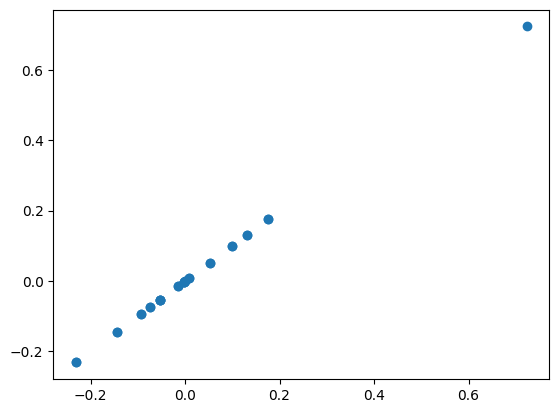

In [52]:
plt.scatter(beta_manual.detach().cpu().numpy(), beta.detach().cpu().numpy())

In [53]:
import time
def m_step(
    q,
    m,                       # posterior mean ∈ ℂⁿ or ℝⁿ
    Sigma_z_batch,           # batched Σ·z: ℝ^{(J,n)}→ℝ^{(J,n)}
    fadj,                    # ℝⁿ→ℂᴹ or ℝⁿ→ℝᴹ
    toeplitz,                # ToeplitzND: ℂᴹ→ℂᴹ
    ws2,                 # spectral-domain weights ∈ ℝᴹ
    Dprime,                  # spectral grads ∈ ℝᴹˣᴾ
    J: int = 5,
    cg_tol: float = 1e-4,
    early_stopping: bool = True
):
    device = m.device
    dtype  = m.dtype
    n      = m.numel()
    M, P   = Dprime.shape
    # center = toeplitz.v_pad[tuple(toeplitz.starts)]
    jitter_val = 1e-10 # or a similar small number

    toeplitz_reg = lambda x: toeplitz(x) + jitter_val * x


    # Precompute once
    t0 = time.time()
    # ws2    = ws_spec.square().to(device=device, dtype=dtype)  # D_i²
    ws2 = ws2 
    Dp     = Dprime.to(device=device, dtype=dtype)            # (M,P)
    fadj_b = vmap(fadj, in_dims=0, out_dims=0)                # (J,n)->(J,M)
    t1 = time.time()
    print(f"[Profile] Precompute: {t1-t0:.6f} s")

    # Buffers
    probes = torch.empty((J,n), device=device, dtype=dtype)
    x0_M   = torch.zeros((J,M), device=device, dtype=dtype)

    # Term I:  <D^{-2}beta, D' D^{-2}beta>
    t2 = time.time()
    rhs1  = fadj(m)                                 # (M,)
    x0_1  = torch.zeros_like(rhs1)                  # complex or real
    beta  = ConjugateGradients(
                toeplitz_reg, rhs1, x0_1,
                tol=1e-5, early_stopping=early_stopping,
            ).solve()                              # (M,)
    ws2_jitter = ws2 + jitter_val
    d2beta = beta / ws2_jitter                            # = D^{-2}beta
    term1 = (d2beta * d2beta.conj()).real @ Dp     # sum_i (d2beta_i)^2 D'_i
    t3 = time.time()
    print(f"[Profile] Term I: {t3-t2:.6f} s")

    # One batch of Rademacher probes
    t4 = time.time()
    # torch.manual_seed(0)
    probes.bernoulli_(0.5).mul_(2).sub_(1)         # ±1
    print(probes.shape)
    t5 = time.time()
    print(f"[Profile] Rademacher probes: {t5-t4:.6f} s")

    # alpha_j = F^* K^{-1} z_j  via solving toeplitz beta-system
    t6 = time.time()
    rhs_alpha  = fadj_b(probes)                    # (J,M)
    x0_alpha  = torch.zeros_like(rhs_alpha)
    t7 = time.time()
    print(f"[Profile] fadj_b: {t7-t6:.6f} s")
    t_alpha = time.time()
    alpha  = ConjugateGradients(
                toeplitz_reg, rhs_alpha, x0_alpha,
                tol=1e-5, early_stopping=early_stopping, 
            ).solve()                             # (J,M)
    t_alpha2 = time.time()
    print(f"[Profile] Alpha solve: {t_alpha2-t_alpha:.6f} s")

    # Term II:  (1/J) sum_j [ w_j * alpha_j ]^T D'
    t8 = time.time()
    Sz    = Sigma_z_batch(probes)                  # (J,n)
    t9 = time.time()
    print(f"[Profile] Sigma_z_batch: {t9-t8:.6f} s")
    rhs_w = fadj_b(Sz)                             # (J,M)
    t10 = time.time()
    print(f"[Profile] fadj_b: {t10-t9:.6f} s")
    x0_w  = torch.zeros_like(rhs_w)
    w     = ConjugateGradients(
                toeplitz_reg, rhs_w, x0_w,
                tol=1e-10, early_stopping=early_stopping, 
            ).solve()                             # (J,M)
    g     = (w.conj()/(ws2) * alpha/(ws2)).sum(dim=0)          # sum_j (w_j * alpha_j)
    term2 = (g.real @ Dp) / J                      # average over J
    t11 = time.time()
    print(f"[Profile] Term II: {t11-t10:.6f} s")

    # Term III: (1/J) sum_j [ (F^* z_j) * alpha_j ]^T D'
    t12 = time.time()
    h     = (rhs_alpha.conj() * alpha/(ws2)).sum(dim=0)  # sum_j (F^*z_j * alpha_j)
    term3 = (h.real @ Dp) / J                      # average over J
    t13 = time.time()
    print(f"[Profile] Term III: {t13-t12:.6f} s")
    t14 = time.time()
    print(f"[Profile] Total m_step: {t14-t0:.6f} s")
    return term1, term2, term3
term1, term2, term3 = m_step(q=q, m=m, Sigma_z_batch=Sigma_z_batch, fadj=fadj, toeplitz=toeplitz, ws2=ws2, Dprime=Dprime, J=10)
# print(term1, term2, term3)
grad_m = 0.5*(term1 + term2 - term3)


[Profile] Precompute: 0.000135 s
[Profile] Term I: 0.003149 s
torch.Size([10, 2000])
[Profile] Rademacher probes: 0.000088 s
[Profile] fadj_b: 0.001878 s
[Profile] Alpha solve: 0.002891 s
[Profile] Sigma_z_batch: 0.241223 s
[Profile] fadj_b: 0.000803 s
[Profile] Term II: 0.003668 s
[Profile] Term III: 0.000022 s
[Profile] Total m_step: 0.254102 s


# make sure close to the autograd 

## testing 

In [54]:
import torch
num_iters = 20
jitter = 1e-10
# def pg_manual_elbo_and_grad(X, y, kernel, num_iters=10, jitter=1e-10):
"""
Returns: (ELBO, grad_var, grad_ls)
for GP classification ELBO under Poly-Gamma augmentation,
with manual gradients for kernel.variance and kernel.lengthscale.
"""
n = x.shape[0]
device = x.device

# 1) Precompute things that don't change in the loop
kappa = y - 0.5                                 # (n,)
Kff   = F_train@(torch.diag(ws2))@F_train.T.conj()      
Kff = Kff.real                     # (n,n)
D2    = torch.cdist(x, x, p=2).pow(2)            # (n,n)

# 2) PG variational parameter
xi = torch.ones(n, device=device)

# 3) Fixed-point updates for (m, S)
for _ in range(1):
    # omega = 0.5/xi * torch.tanh(xi/2)            # (n,)
    omega = q.Delta

    # build K = Kff + jitter·I
    K = Kff + jitter*torch.eye(n, device=device)
    L = torch.linalg.cholesky(K)                # K = L Lᵀ

    # K⁻¹ via Cholesky
    I = torch.eye(n, device=device)
    K_inv = torch.cholesky_solve(I, L)          # (n,n)

    # S⁻¹ = K⁻¹ + diag(ω)  ⇒  S = (S⁻¹)⁻¹
    S_inv = K_inv + torch.diag(omega)
    LS    = torch.linalg.cholesky(S_inv)
    S     = torch.cholesky_inverse(LS)          # (n,n)

    # posterior mean m = S κ
    # m = S @ kappa                               # (n,)

    # 4) Compute ELBO = E_q[log p(y,f,ω)] − E_q[log q(f,ω)]
    # 4a) likelihood term
    elbo_lik = (kappa*m
                - 0.5*omega*(m**2 + torch.diagonal(S))
                - torch.log(torch.tensor(2.0, device=device))).sum()
    # 4b) prior term
    m_col     = m.T                
    Kinv_m    = torch.cholesky_solve(m_col, L).squeeze(-1)
    quad       = (m * Kinv_m).sum()
    trace_S    = torch.trace(torch.cholesky_solve(S, L))
    logdet_K   = 2.0*torch.sum(torch.log(torch.diagonal(L)))
    elbo_prior = -0.5*(quad + trace_S + logdet_K + n*math.log(2*torch.pi))
    elbo       = elbo_lik + elbo_prior

    # 5) Manual gradients
    var = kernel.variance
    ls  = kernel.lengthscale

    # ∂K/∂var and ∂K/∂ls
    dK_dvar = F_train@torch.diag(Dprime[:,1].to(dtype=cdtype))@F_train.T.conj()
    dK_dls  = F_train@torch.diag(Dprime[:,0].to(dtype=cdtype))@F_train.T.conj()

    # helper: v = K⁻¹ m
    v = torch.cholesky_solve(m_col, L).squeeze(-1)

    # grad wrt variance
    t1var = v @ (dK_dvar.to(dtype=rdtype ) @ v)
    t2var = torch.trace(K_inv @ dK_dvar.to(dtype=rdtype) @ K_inv @ S)
    t3var = torch.trace(K_inv @ dK_dvar.to(dtype=rdtype))
    grad_var = 0.5*(t1var + t2var - t3var)

    # grad wrt lengthscale
    t1 = v @ (dK_dls.to(dtype=rdtype) @ v)
    # print(v[0])
    # print(dK_dls[0])
    t2 = torch.trace(K_inv @ dK_dls.to(dtype=rdtype) @ K_inv @ S)
    t3 = torch.trace(K_inv @ dK_dls.to(dtype=rdtype))
    grad_ls = 0.5*(t1 + t2 - t3)

      # return t1,t2,t3, grad_var, grad_ls
# print(t1,t2,t3,elbo)
t1v1=t1
t2v1=t2
t3v1=t3
elbo1=elbo


In [55]:

print('##Lengthscale##')
print(f'term1: {term1[0]}, term2: {term2[0]}, term3: {term3[0]}, ')
# print(f't1: {t1}, t2: {t2}, t3: {t3}, elbo: {elbo}')
print(f't1v1: {t1v1}, t2v1: {t2v1}, t3v1: {t3v1}, elbo1: {elbo1}')
print('##Variance##')
print(f't1var: {term1[1]}, t2var: {term2[1]}, t3var: {term3[1]}')
print(f't1v1: {t1var}, t2v1: {t2var}, t3v1: {t3var}')
print('### Grad###')
print(f'grad_m: {grad_m}')
print(f'grad_ls: {grad_ls}')
print(f'grad_var: {grad_var}')


##Lengthscale##
term1: -211.02862068816034, term2: -1098.9011329235195, term3: -1491.0654173823136, 
t1v1: -209.07895019630163, t2v1: -975.0543130723394, t3v1: -1404.255597552472, elbo1: 18575.374362506882
##Variance##
t1var: 6.962965559810172, t2var: 5.740084302840171, t3var: 15.332753467477854
t1v1: 6.920114328551218, t2v1: 5.632171168202398, t3v1: 15.499833952466293
### Grad###
grad_m: tensor([90.5678, -1.3149])
grad_ls: 110.06116714191546
grad_var: -1.4737742278563388
